***

## 4. Modeling

***

**Import Packages:**

In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn import dummy, metrics
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
from IPython.display import Image

***

**Set Random Seed:**

In [2]:
#random seed for repeatability
random_seed = 18

***

**Read Data Into Pandas:**

In [3]:
#read the data into pandas

filepath = '../data/X_train.csv'
X_train = pd.read_csv(filepath)

filepath = '../data/y_train.csv'
y_train = pd.read_csv(filepath)

filepath = '../data/X_test.csv'
X_test = pd.read_csv(filepath)

filepath = '../data/y_test.csv'
y_test = pd.read_csv(filepath)

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7354 entries, 0 to 7353
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   InSprayBounds_1             7354 non-null   float64
 1   IsDayAfterSpray_1           7354 non-null   float64
 2   IsNorthWestZone_1           7354 non-null   float64
 3   MoistureConditions_Optimal  7354 non-null   float64
 4   MoistureConditions_Poor     7354 non-null   float64
 5   NumMosquitos                7354 non-null   float64
 6   PrecipTotal_lag1            7354 non-null   float64
 7   PrecipTotal_lag23           7354 non-null   float64
 8   PrecipTotal_lag27           7354 non-null   float64
 9   PrecipTotal_lag28_mean      7354 non-null   float64
 10  PrecipWeekly_Score_3        7354 non-null   float64
 11  PrecipWeekly_Score_5        7354 non-null   float64
 12  RelHumidity_lag10           7354 non-null   float64
 13  RelHumidity_lag4            7354 

***

## 4.1 Undersample the Training Data

In [5]:
def undersample(X, y, random_seed):
    #set undersample size to the number of rows in the minority class
    undersample_size = y.value_counts().min()
    
    #concatenate the X_train and y_train datasets
    us_data = pd.concat([X,y],axis=1)
    
    #minority/positive class
    pos_us_data = us_data[us_data['WnvPresent']==1]

    #sample the majority/negative class (n samples = undersample size)
    neg_us_data = us_data[us_data['WnvPresent']==0].sample(undersample_size, random_state=random_seed)

    #concatenate the two datasets to create the undersampled dataset
    us_data = pd.concat([neg_us_data, pos_us_data], axis=0)

    #Separate the Input Features (X) and Target Feature (y)
    X_train_us = us_data.drop(columns='WnvPresent')
    y_train_us = us_data[['WnvPresent']]
    
    return (X_train_us, y_train_us)

***

## 4.2 Train and Test Different Models

***

**DataFrame to Track Model AUC Scores:**

In [6]:
df_test_results = pd.DataFrame(columns = ['Model','TrainAUC','TestAUC'])

***

**Method to train, predict, and score each model:**

In [7]:
def train_predict_score(model, X_train, y_train, X_test, y_test, random_seed):
    
    #undersample the training data
    X_train_us, y_train_us = undersample(X_train,y_train, random_seed)
    
    #fit the model
    model.fit(X_train_us,np.ravel(y_train_us))
    
    #make predictions on the train and test sets
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
        
    #score the model (using AUC)
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    return (train_auc, test_auc)

***

**Method to print AUC scores and get the test results dataframe row:**

In [8]:
def handle_scores(model_name, scores):
    
    #print AUC scores
    print('Training AUC: ', scores[0])
    print('Test AUC: ', scores[1])
    
    #return the test results row for the test results dataframe
    test_results_row = {'Model':model_name,'TrainAUC':scores[0],'TestAUC':scores[1]}
    
    return test_results_row

***

## 4.2.1 Baseline Model

In [9]:
#Baseline model
dummy_model = DummyClassifier(random_state = random_seed, strategy='uniform')

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(dummy_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Baseline Model', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.5
Test AUC:  0.5


***

## 4.2.2 Logistic Regression

In [10]:
#Logistic Regression model
lr_model = LogisticRegression(random_state = random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(lr_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Logistic Regression', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.868971887771188
Test AUC:  0.8351158048513254


***

## 4.2.3 Support Vector Machine

In [11]:
#SVM model
svm_model = SVC(random_state = random_seed, probability=True)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(svm_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Support Vector Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.8806105854743818
Test AUC:  0.8230077811932516


***

## 4.2.4 Random Forest 

In [12]:
#Random Forest model
rf_model = RandomForestClassifier(random_state = random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(rf_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Random Forest Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.9284447258526023
Test AUC:  0.797383611812805


***

## 4.2.5 Gradient Boosting

In [13]:
#Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state = random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(gb_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Gradient Boosting Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)


Training AUC:  0.9068428285039529
Test AUC:  0.8389008937720019


***

## 4.2.6 XGBoost

In [14]:
#XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, seed=random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(xgb_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('XGBoost Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

[11:46:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training AUC:  0.9145828747851019
Test AUC:  0.8073966988262267


***

## 4.2.7 LightGBM

In [15]:
#LightGBM model
lgb_model = LGBMClassifier(random_state = random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(lgb_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('LightGBM Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.9162914626746697
Test AUC:  0.8133162897809701


***

## 4.2.8 AdaBoost

In [16]:
#AdaBoost model
ada_model = AdaBoostClassifier(random_state = random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(ada_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('AdaBoost Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.879391652736715
Test AUC:  0.8345060920554728


***

## 4.2.9 ExtraTrees Classifier

In [17]:
#Extra Trees model
et_model = ExtraTreesClassifier(random_state = random_seed)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(et_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Extra Trees Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.942394692539693
Test AUC:  0.767761309107141


***

## 4.3 Initial Test Results

In [18]:
df_test_results.sort_values(by='TestAUC', ascending=False)

,Model,TrainAUC,TestAUC
4,Gradient Boosting Classifier,0.906843,0.838901
1,Logistic Regression,0.868972,0.835116
7,AdaBoost Classifier,0.879392,0.834506
2,Support Vector Classifier,0.880611,0.823008
6,LightGBM Classifier,0.916291,0.813316
5,XGBoost Classifier,0.914583,0.807397
3,Random Forest Classifier,0.928445,0.797384
8,Extra Trees Classifier,0.942395,0.767761
0,Baseline Model,0.500000,0.500000


Initial modeling favours the **Gradient Boosting Classifier**. Hyperparameter tuning will be used in an attempt to improve on the best model. 

***

## 4.4 Hyperparameter Tuning

***

**Search for best Gradient Boosting Classifier hyperparameters:**

In [19]:
#define the hyperparameter search grid
grid_params = {
    'learning_rate':[0.001,0.01,0.1, 1],
    'max_depth':[3,6,7,8,9,10],
    'subsample':[0.25,0.5,0.75,1],
    'max_features':['sqrt','log2',1],
}

#Gradient Boosting model (best score in initial modeling)
gb_model = GradientBoostingClassifier(random_state = random_seed)

#Randomized CV search for best hyperparameters
tuned_gb_model = RandomizedSearchCV(gb_model,grid_params, scoring='roc_auc',n_jobs=-1, cv=15, random_state=random_seed,
                                n_iter=30)

#train the model, make predictions on train and test sets, get AUC scores
scores = train_predict_score(tuned_gb_model, X_train, y_train, X_test, y_test, random_seed)

#append AUC scores to test results dataframe, print AUC scores
results_row = handle_scores('Tuned Gradient Boosting Classifier', scores)
df_test_results = df_test_results.append(results_row,ignore_index=True)

Training AUC:  0.900439574249121
Test AUC:  0.8425348226151708


***

**Best parameters:**

In [20]:
tuned_gb_model.best_params_

{'subsample': 0.75,
 'max_features': 'log2',
 'max_depth': 3,
 'learning_rate': 0.1}

***

## 4.5 Final Results

***

**Model Scores:**

In [21]:
df_test_results.sort_values(by='TestAUC', ascending=False)

,Model,TrainAUC,TestAUC
9,Tuned Gradient Boosting Classifier,0.900440,0.842535
4,Gradient Boosting Classifier,0.906843,0.838901
1,Logistic Regression,0.868972,0.835116
7,AdaBoost Classifier,0.879392,0.834506
2,Support Vector Classifier,0.880611,0.823008
6,LightGBM Classifier,0.916291,0.813316
5,XGBoost Classifier,0.914583,0.807397
3,Random Forest Classifier,0.928445,0.797384
8,Extra Trees Classifier,0.942395,0.767761
0,Baseline Model,0.500000,0.500000


Hyperparameter tuning did improve the performance of the Gradient Boosting Classifier. Therefore, the **Tuned Gradient Boosting Classifier** will be the final model.

***

**ROC curve for the Tuned Gradient Boosting Classifier:**

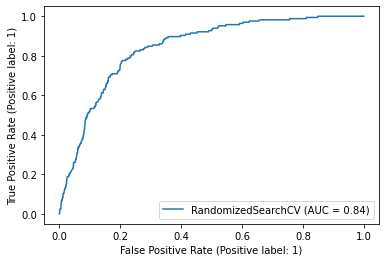

In [22]:
#plot the roc curve for the best model
plot_roc_curve(tuned_gb_model, X_test, y_test);

***

## 4.6 SHAP Analysis

***

## 4.6.1 SHAP Summary Plot

***

**Note:** the SHAP summary plot has been loaded from an image due to the code's long running time. However, the code below can be un-commented and used to generate the SHAP summary plot instead of using the image.

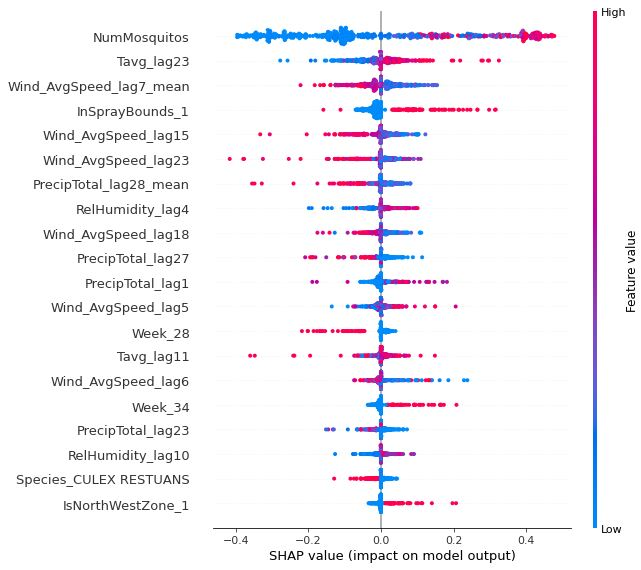

In [23]:
#load SHAP Summary Plot image
Image(filename='../Images/SHAP_Summary_600samples.JPG') 

In [24]:
#get SHAP values

#X_test_sample = shap.sample(X_test,600)
#explainer = shap.KernelExplainer(tuned_gb_model.predict, X_test_sample)
#shap_values = explainer.shap_values(X_test_sample)


In [25]:
#create SHAP summary plot

#shap.summary_plot(shap_values, X_test_sample)

***

## 4.6.2 Feature Importance Conclusions:

***

**Top 5 Features:**
* The **number of mosquitoes** caught in a trap was the most important predictor of whether West Nile virus would be present. This makes sense because, even when West Nile conditions are optimal, there is not necessarily a high likelihood that any individual mosquito will be West Nile positive. As more mosquitos are caught in a trap, it becomes more likely that at least one mosquito will be West Nile positive. 
* As the **average daily temperature with a 23-day lag** increased, it was more likely that West Nile virus would be present. Mosquitos tend to thrive in warmer environments so this was not surprising. The warmer temperatures likely led to improved mosquito breeding conditions and, therefore, higher mosquito population numbers. However, the effect will not be seen immediately. The length of the mosquito life cycle tends to be 2-4 weeks (although it can be shorter depending on weather conditions). This is a likely explanation for the importance of the 23-day lag.
* As the **mean wind speed from 7-14 days prior** increased, the presence of West Nile virus decreased. Higher wind speeds likely make it more difficult for mosquitos to fly, reducing both their ability to fly greater distances and to accurately fly to their target destination. Therefore, higher wind speeds may result in reduced mosquito breeding. The importance of the 7-14 day lag is likely due to the length of the mosquito life cycle which tends to be 2-4 weeks, but can be as short as one week in peak summer conditions.
* Traps were considered **within the spray boundaries** when they were inside the box created by the northernmost, southernmost, easternmost, westernmost spray location (up to that point in the year). The trap locations within the spray boundaries tended to have a much higher West Nile presence. This is likely due to correlation rather than causation. Spraying may have been a reactive response in areas that were already known to have either high levels of West Nile presence or high mosquito counts. It makes sense that spray boundaries, not only the spray zones, were important because individual mosquitos are not necessarily confined to a small area. Mosquitos have a maximum flight distance of 50m to 50km, depending on the species. Therefore, if there is a high mosquito count in one area, it is likely that there will be a high mosquito count in neighbouring areas (assuming relatively similar environments). This should hold true for West Nile presence as well.
* As **average wind speed with a 15-day lag** increased, the presence of West Nile virus decreased. As mentioned above, higher wind speeds likely reduce both the distance mosquitos are able to fly and the ability of a mosquito to accurately fly to a target destination. This can be expected to result in reduced mosquito breeding. A delayed impact on mosquito population numbers would be observed, since the mosquito life cycle takes 2-4 weeks. Again, this explains the importance of the 15 day lag. 

**Other Observations Related to Feature Importance:**
* A **23-day lag** seemed to be especially significant. Temperature and average wind speed lagged by 23 days both showed up in the top 6 most important features. Total precipitation lagged by 23 days also showed some importance. The typical mosquito life cycle is 2-4 weeks and varies based on environmental factors including temperature and moisture levels. It is possible that a life cycle of roughly 23 days tends to be common in the conditions created by the Chicago climate.
* Higher **relative humidity** tended to go along with higher West Nile virus presence. Importance in relative humidity was seen for both a 4-day and 10-day lag. With the 4-day lag time, it is likely that mosquito activity increased with humidity, resulting in a higher number of mosquitoes being caught in the traps. Since traps were not checked daily, mosquitos may be caught in a trap for a few days before being discovered. With the 10-day lag time, it is likely that increased humidity improved breeding conditions for mosquitos. The mosquito life cycle is shorter in peak summer heat (which is often accompanied by high humidity levels). This may explain why a 10-day lag was important with relative humidity rather than the longer lag times associated with other weather features.
* The mosquito **species** showed some importance in the model. Only two species - Culex Restuans and Culex Pipiens - were caught in significant numbers. These were also the only two species that were observed to be West Nile virus positive. **Culex Restuans**  mosquitoes were less likely to test positive for West Nile virus.  
* Among **location** based features, the **Northwest Zone** identified during the EDA phase was positively correlated with the presence of West Nile. It is possible that this area provides an optimal environment for either mosquitoes or for bird species that are susceptible to West Nile virus (since mosquitoes become West Nile virus carriers by biting birds infected with the disease).
* **Seasonality** also played a role in West Nile virus prediction, as week of the year indicators appeared in the top 20 most important features. Weeks 28 and 34 had negative and positive correlations with the presence of West Nile virus respectively.
* **Precipitation** had a varied effect, but the two most important precipitation features had long lag times (mean precipitation with a lag of 28-35 days, and precipitation with a lag of 27 days). In these two cases, precipitation was negatively correlated with West Nile virus. This may be due to the fact that water sources become more scarce in dry conditions. Culex species tend to disperse more widely under these conditions, as adequate breeding grounds become more scarce. Additionally, contact between birds and mosquitoes tends to increase in dry conditions, as they both rely on the few remaining water sources. This increases the likelihood that mosquitoes will bite a bird that is infected with West Nile virus. On the other hand, mosquito numbers tend to increase in rainy conditions. This may explain why precipitation can have a varied impact on the presence of West Nile virus.  

**References:**
* https://www.in.gov/health/erc/zoonotic-and-vectorborne-epidemiology-entomology/pests/culex-species-mosquitoes/
* https://www.sciencedirect.com/science/article/pii/S0075951113001011
* https://www.orkin.com/pests/mosquitoes/mosquito-life-cycle-facts
* https://www.medicalnewstoday.com/articles/west-nile-virus-in-the-us-a-case-study-on-climate-change-and-health#The-West-Nile-virus-in-the-U.S.

***